In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gdelt = pd.read_parquet('../cache/gdelt_cleaned.parquet')

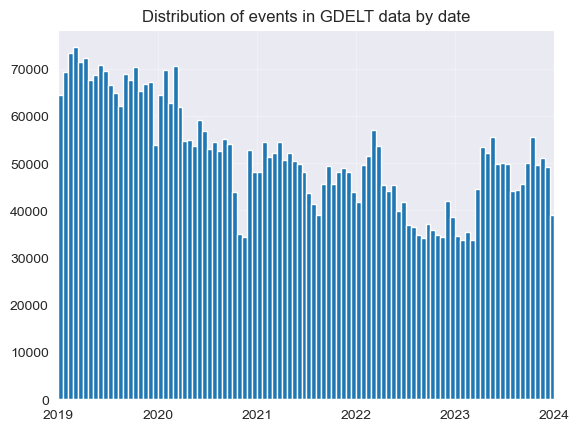

In [3]:
gdelt.Date.hist(bins=100)
plt.xlim([pd.Timestamp('2019-01-01'), pd.Timestamp('2024-01-01')])
plt.grid(True, alpha=0.3)
plt.title('Distribution of events in GDELT data by date')
plt.show()

We can see that the number of events in the database decreases slightly over time but not significantly. There are no major gaps in the data.

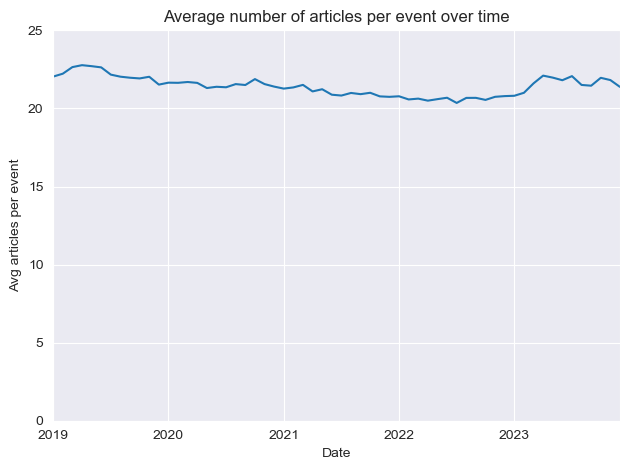

In [4]:
# avg number of articles per event over time
gdelt.groupby(gdelt['Date'].dt.to_period('M'))['NumArticles'].mean().plot()
plt.ylim([0, 25])
plt.title('Average number of articles per event over time')
plt.ylabel('Avg articles per event')
plt.tight_layout()

The average number of articles per event is relatively stable over time.

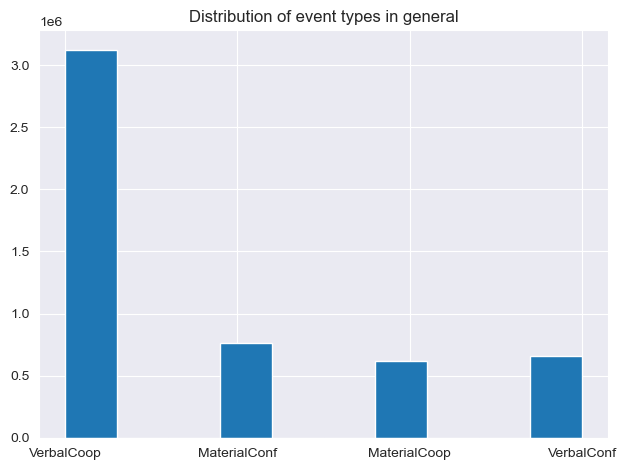

In [5]:
gdelt.QuadClass.hist()
plt.title('Distribution of event types in general')
plt.tight_layout()
plt.show()

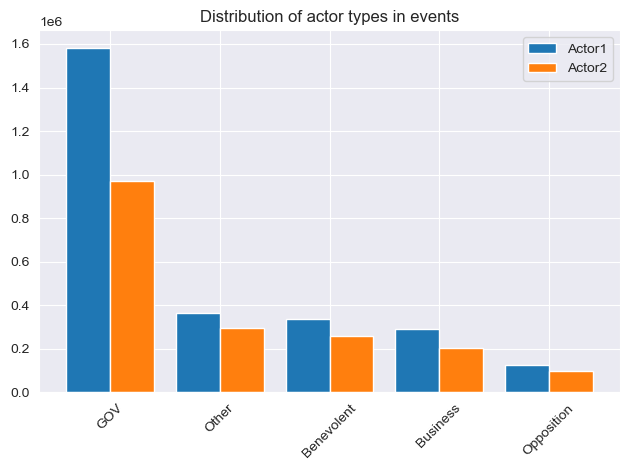

In [6]:
actor1_counts = gdelt.Actor1TypeGeneral.value_counts()
actor2_counts = gdelt.Actor2TypeGeneral.value_counts()

comparison = pd.DataFrame({'Actor1': actor1_counts, 'Actor2': actor2_counts})
comparison.plot(kind='bar', width=0.8)
plt.title('Distribution of actor types in events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
from funcs.impact_scoring import calc_event_impact, calc_event_magnitude, get_impact_bin

In [8]:
gdelt['Magnitude'] = gdelt.apply(calc_event_magnitude, axis=1)
gdelt['Impact'] = gdelt.apply(calc_event_impact, axis=1)
gdelt['ImpactBin'] = gdelt['Impact'].apply(get_impact_bin)

In [9]:
from funcs.advanced_describe import advanced_describe

description_df = advanced_describe(gdelt, drop_cols=['Source'])

In [15]:
description_df = description_df[['present', 'unique', 'dtype', 'mean', 'std', 'min', 'max']]

In [16]:
description_df

,present,unique,dtype,mean,std,min,max
Date,100%,NaN,datetime64[ns],2021-04-07 23:29:41.304720128,NaN,2019-01-01 00:00:00,2023-12-31 23:45:00
Timestamp,100%,NaN,int64,1617838181.304721,46733483.410458,1546300800.0,1704066300.0
Actor1Country,44%,21,object,NaN,NaN,NaN,NaN
Actor1GeoCountry,83%,21,object,NaN,NaN,NaN,NaN
Actor1Type,52%,32,category,NaN,NaN,NaN,NaN
Actor1TypeGeneral,52%,5,object,NaN,NaN,NaN,NaN
Actor2Country,32%,21,object,NaN,NaN,NaN,NaN
Actor2GeoCountry,58%,21,object,NaN,NaN,NaN,NaN
Actor2Type,35%,32,category,NaN,NaN,NaN,NaN
Actor2TypeGeneral,35%,5,object,NaN,NaN,NaN,NaN


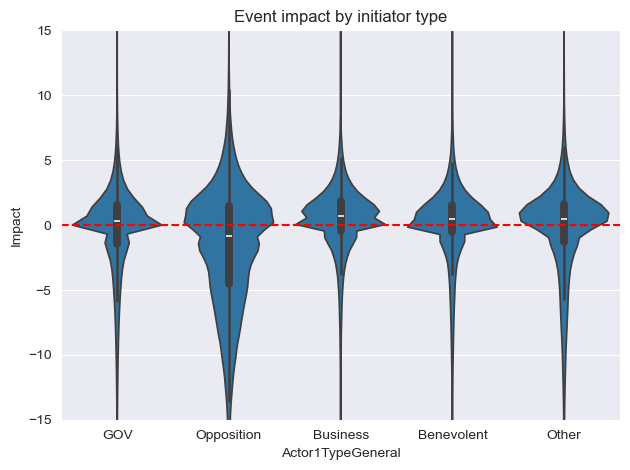

In [10]:
sns.violinplot(x='Actor1TypeGeneral', y='Impact', data=gdelt,
               order=['GOV', 'Opposition', 'Business', 'Benevolent', 'Other'], density_norm='width')
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim([-15, 15])
plt.title('Event impact by initiator type')
plt.xlabel = "Initiating actor type"
plt.tight_layout()
plt.show()

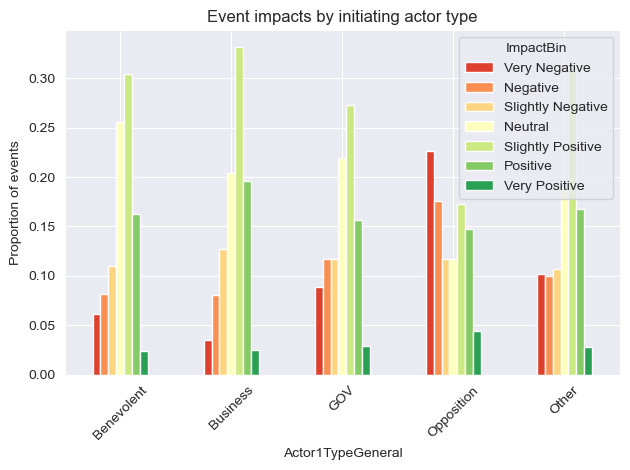

In [11]:
impact_by_actor1type = pd.crosstab(gdelt.Actor1TypeGeneral, gdelt.ImpactBin, normalize='index').reindex(
    columns=['Very Negative', 'Negative', 'Slightly Negative', 'Neutral', 'Slightly Positive', 'Positive',
             'Very Positive'])
colors = sns.color_palette('RdYlGn', 7)
impact_by_actor1type.plot(kind='bar', color=colors)
plt.title('Event impacts by initiating actor type')
plt.ylabel('Proportion of events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

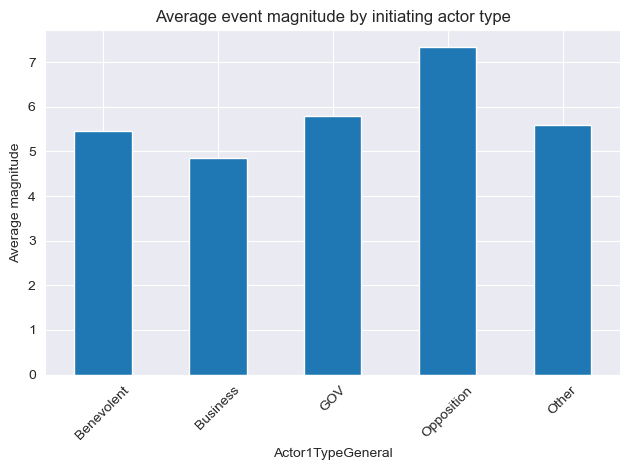

In [12]:
gdelt.groupby('Actor1TypeGeneral')['Magnitude'].mean().plot(kind='bar')
plt.title('Average event magnitude by initiating actor type')
plt.ylabel('Average magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

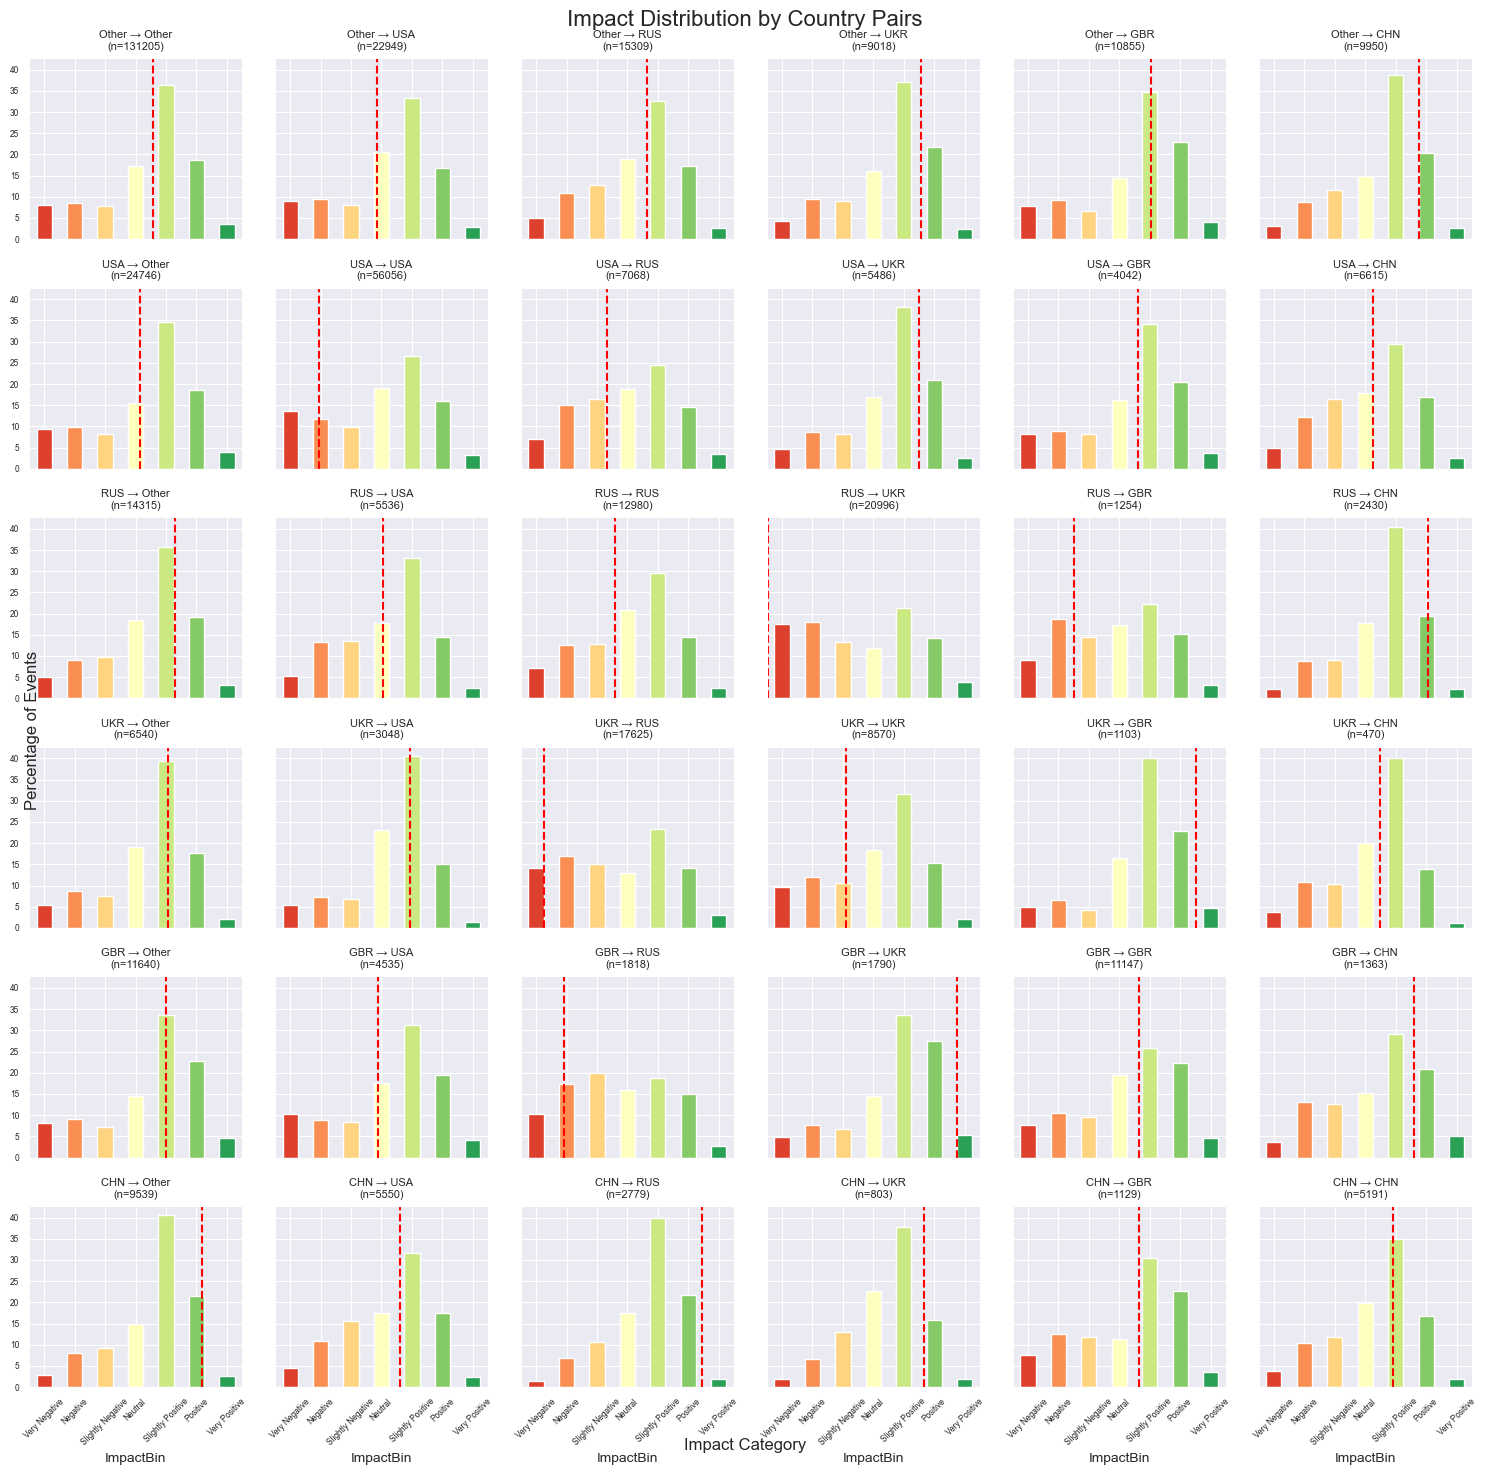

In [13]:
top_countries = set(gdelt['Actor1Country'].value_counts().head(6).index) & \
                set(gdelt['Actor2Country'].value_counts().head(6).index)

filtered_gdelt = gdelt[
    (gdelt['Actor1Country'].isin(top_countries)) &
    (gdelt['Actor2Country'].isin(top_countries))
    ]

fig, ax = plt.subplots(len(top_countries), len(top_countries), figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Impact Distribution by Country Pairs', fontsize=16)

colors = sns.color_palette('RdYlGn', 7)

countrysort = lambda x: -gdelt['Actor1Country'].value_counts()[x]

for i, country1 in enumerate(sorted(top_countries, key=countrysort)):
    for j, country2 in enumerate(sorted(top_countries, key=countrysort)):
        pair_data = filtered_gdelt[
            (filtered_gdelt['Actor1Country'] == country1) &
            (filtered_gdelt['Actor2Country'] == country2)
            ]

        impact_dist = pair_data['ImpactBin'].value_counts(normalize=True) * 100
        impact_dist = impact_dist.reindex(
            ['Very Negative', 'Negative', 'Slightly Negative', 'Neutral', 'Slightly Positive', 'Positive',
             'Very Positive'])

        impact_dist.plot(kind='bar', ax=ax[i, j], color=colors)
        
        mean_impact = pair_data['Impact'].mean() * 3 + 3
        ax[i, j].axvline(x=mean_impact, color='red', linestyle='--')

        ax[i, j].set_title(f'{country1} → {country2}\n(n={len(pair_data)})', fontsize=8)
        ax[i, j].tick_params(axis='both', labelsize=6)
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=45)

# Add common labels
fig.text(0.5, 0.02, 'Impact Category', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'Percentage of Events', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.show()